In [21]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
!nvidia-smi

Sun Aug 25 16:13:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Collaborative filtering embeddings

In [3]:
# Load the dataset
df=pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [4]:
# Checking if there are any duplicate rows
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [5]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))

In [7]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

print(f"Number of samples in the training set: {len(y_train)}, test set: {len(y_test)}")

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [9]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [10]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model

model = RecommenderNet(num_users, num_animes)
# Printing my model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_encoded (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 anime_encoded (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       34564224    ['user_encoded[0][0]']           
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2112000     ['anime_encoded[0][0]']          
                                                                                              

In [12]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/kaggle/working/collaborative_filtering_weights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [13]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
2432/2432 [==============================] - 106s 41ms/step - loss: 0.6739 - mae: 0.2461 - mse: 0.0801 - val_loss: 0.6552 - val_mae: 0.2274 - val_mse: 0.0704 - lr: 1.0000e-05
Epoch 2/20
2432/2432 [==============================] - 40s 16ms/step - loss: 0.6248 - mae: 0.1990 - mse: 0.0559 - val_loss: 0.5990 - val_mae: 0.1713 - val_mse: 0.0432 - lr: 1.8000e-05
Epoch 3/20
2432/2432 [==============================] - 39s 16ms/step - loss: 0.5837 - mae: 0.1535 - mse: 0.0368 - val_loss: 0.5771 - val_mae: 0.1467 - val_mse: 0.0336 - lr: 2.6000e-05
Epoch 4/20
2432/2432 [==============================] - 37s 15ms/step - loss: 0.5761 - mae: 0.1447 - mse: 0.0336 - val_loss: 0.5746 - val_mae: 0.1421 - val_mse: 0.0326 - lr: 3.4000e-05
Epoch 5/20
2432/2432 [==============================] - 36s 15ms/step - loss: 0.5626 - mae: 0.1304 - mse: 0.0285 - val_loss: 0.5578 - val_mae: 0.1252 - val_mse: 0.0263 - lr: 4.2000e-05
Epoch 6/20
2432/2432 [==============================] - 36s 15ms/step - lo

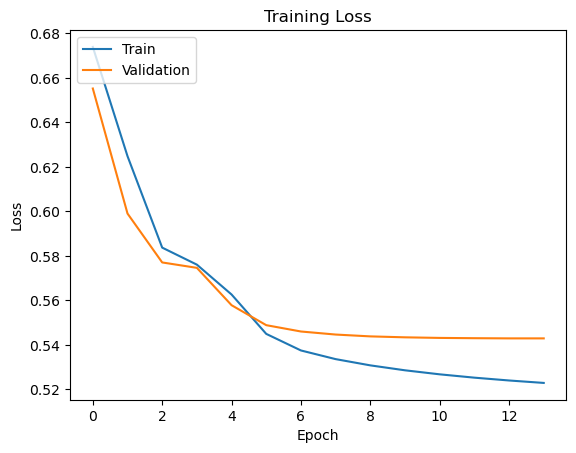

In [14]:
# Training results visualization

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [15]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)

In [22]:
collaborative_filtering_df = pd.DataFrame(anime_weights)
collaborative_filtering_df['anime_id'] = collaborative_filtering_df.apply(lambda row: anime_encoder.inverse_transform([row.name])[0], axis = 1)

# File path for saving the embedding
collaborative_filtering_embeddings_filepath = '/kaggle/working/collaborative_filtering_embeddings.csv'
collaborative_filtering_df.to_csv(collaborative_filtering_embeddings_filepath)

# Content Based Embeddings

In [24]:
df_anime=pd.read_csv('/kaggle/input/myanimelist-dataset/anime-dataset-2023.csv')

In [26]:
# Only take into account the animes with members >= popularity threshold
popularity_threshold = 1000
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(5)

(12638, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


In [27]:
# Save the filtered animes
anime_dataset_filepath = '/kaggle/working/anime_dataset.csv'
df_anime.to_csv(anime_dataset_filepath)

In [30]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

content_based_df = pd.DataFrame(tfidf_matrix_generator.toarray())
content_based_df['anime_id'] = df_anime['anime_id']
content_based_df['anime_id'] = content_based_df.apply(lambda row: df_anime.iloc[row.name]['anime_id'], axis = 1)
print(content_based_df.shape)
content_based_df.head()

(12638, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,anime_id
0,0.259908,0.000000,0.0,0.604519,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.317461,0.0,0.0,0.000000,0.0,0.0,0.604519,1
1,0.501015,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.611957,0.0,0.0,0.000000,0.0,0.0,0.000000,5
2,0.429127,0.516123,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.524150,0.0,0.0,0.000000,0.0,0.0,0.000000,6
3,0.356011,0.000000,0.0,0.000000,0.0,0.0,0.452928,0.0,0.0,0.00000,...,0.617413,0.0,0.000000,0.0,0.0,0.535643,0.0,0.0,0.000000,7
4,0.000000,0.540834,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.49976,...,0.000000,0.0,0.000000,0.0,0.0,0.676563,0.0,0.0,0.000000,8


In [31]:
# File path for saving content-based embeddings
content_based_embeddings_filepath = '/kaggle/working/content_based_embeddings.csv'
content_based_df.to_csv(content_based_embeddings_filepath)